<a href="https://colab.research.google.com/github/Jesseamukowa/Jesse-python/blob/main/Skin_Cancer_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns


In [51]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)
print(f"Dataset shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print(f"\nFirst few rows:")
print(data.head())

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000
Dataset shape: (10015, 2353)
Columns: ['pixel0000', 'pixel0001', 'pixel0002', 'pixel0003', 'pixel0004', 'pixel0005', 'pixel0006', 'pixel0007', 'pixel0008', 'pixel0009', 'pixel0010', 'pixel0011', 'pixel0012', 'pixel0013', 'pixel0014', 'pixel0015', 'pixel0016', 'pixel0017', 'pixel0018', 'pixel0019', 'pixel0020', 'pixel0021', 'pixel0022', 'pixel0023', 'pixel0024', 'pixel0025', 'pixel0026', 'pixel0027', 'pixel0028', 'pixel0029', 'pixel0030', 'pixel0031', 'pixel0032', 'pixel0033', 'pixel0034', 'pixel0035', 'pixel0036', 'pixel0037', 'pixel0038', 'pixel0039', 'pixel0040', 'pixel0041', 'pixel0042', 'pixel0043', 'pixel0044', 'pixel0045', 'pixel0046', 'pixel0047', 'pixel0048', 'pixel0049', 'pixel0050', 'pixel0051', 'pixel0052', 'pixel0053', 'pixel0054', 'pixel0055', 'pixel0056', 'pixel0057', 'pixel0058', 'pixel0059', 'pixel0060', 'pixel0061', 'pixel0062

In [52]:
import pandas as pd
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [53]:
# Separate features and labels
X = data.drop('label', axis=1).values
y = data['label'].values

# Reshape X from flat array to 28x28x3 images
# Original shape: (n_samples, 2352) where 2352 = 28*28*3
X = X.reshape(-1, 28, 28, 3)

# Normalize pixel values to [0, 1]
X = X.astype('float32') / 255.0

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Pixel value range: [{X.min()}, {X.max()}]")

# Class distribution
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
class_counts = pd.Series(y).value_counts().sort_index()
print(f"\nClass distribution:")
for i, (cls, count) in enumerate(zip(classes, class_counts)):
    print(f"  {i} ({cls}): {count}")



X shape: (10015, 28, 28, 3)
y shape: (10015,)
Pixel value range: [0.0, 1.0]

Class distribution:
  0 (akiec): 327
  1 (bcc): 514
  2 (bkl): 1099
  3 (df): 115
  4 (mel): 6705
  5 (nv): 142
  6 (vasc): 1113


In [72]:
# 3. TRAIN/VAL/TEST SPLIT


# First, check class distribution
print("\nOriginal class distribution:")
unique, counts = np.unique(y, return_counts=True)
for cls_idx, count in zip(unique, counts):
    print(f"  {classes[cls_idx]}: {count} ({count/len(y)*100:.1f}%)")

# Calculate split sizes
n_samples = len(X)
n_test = int(0.15 * n_samples)
n_val = int(0.15 * n_samples)
n_train = n_samples - n_test - n_val

print(f"\nSplitting: {n_train} train, {n_val} validation, {n_test} test")

# Option 1: Using train_test_split twice (corrected)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=(n_val + n_test)/n_samples, random_state=42, stratify=y
)

# Now split temp into val and test (50/50 of the temp set)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=n_test/(n_val + n_test), random_state=42, stratify=y_temp
)

print(f"\nActual split sizes:")
print(f"Train samples: {len(X_train)} ({len(X_train)/n_samples*100:.1f}%)")
print(f"Validation samples: {len(X_val)} ({len(X_val)/n_samples*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/n_samples*100:.1f}%)")

# Verify stratification worked for all sets
def print_distribution(name, y_data, classes):
    print(f"\n{name} class distribution:")
    unique_data, counts_data = np.unique(y_data, return_counts=True)
    for cls_idx, count in zip(unique_data, counts_data):
        print(f"  {classes[cls_idx]}: {count} ({count/len(y_data)*100:.1f}%)")

print_distribution("Train", y_train, classes)
print_distribution("Validation", y_val, classes)
print_distribution("Test", y_test, classes)

# Option 2: Using StratifiedShuffleSplit for more control
from sklearn.model_selection import StratifiedShuffleSplit

print("\n" + "="*50)
print("Alternative: Using StratifiedShuffleSplit")
print("="*50)

sss = StratifiedShuffleSplit(n_splits=1, test_size=n_test/n_samples, random_state=42)
for train_val_idx, test_idx in sss.split(X, y):
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=n_val/(n_train + n_val), random_state=42)
for train_idx, val_idx in sss2.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

print(f"\nAlternative split sizes:")
print(f"Train samples: {len(X_train)} ({len(X_train)/n_samples*100:.1f}%)")
print(f"Validation samples: {len(X_val)} ({len(X_val)/n_samples*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/n_samples*100:.1f}%)")


Original class distribution:
  akiec: 327 (3.3%)
  bcc: 514 (5.1%)
  bkl: 1099 (11.0%)
  df: 115 (1.1%)
  mel: 6705 (66.9%)
  nv: 142 (1.4%)
  vasc: 1113 (11.1%)

Splitting: 7011 train, 1502 validation, 1502 test

Actual split sizes:
Train samples: 7011 (70.0%)
Validation samples: 1502 (15.0%)
Test samples: 1502 (15.0%)

Train class distribution:
  akiec: 229 (3.3%)
  bcc: 360 (5.1%)
  bkl: 769 (11.0%)
  df: 81 (1.2%)
  mel: 4694 (67.0%)
  nv: 99 (1.4%)
  vasc: 779 (11.1%)

Validation class distribution:
  akiec: 49 (3.3%)
  bcc: 77 (5.1%)
  bkl: 165 (11.0%)
  df: 17 (1.1%)
  mel: 1005 (66.9%)
  nv: 22 (1.5%)
  vasc: 167 (11.1%)

Test class distribution:
  akiec: 49 (3.3%)
  bcc: 77 (5.1%)
  bkl: 165 (11.0%)
  df: 17 (1.1%)
  mel: 1006 (67.0%)
  nv: 21 (1.4%)
  vasc: 167 (11.1%)

Alternative: Using StratifiedShuffleSplit

Alternative split sizes:
Train samples: 7011 (70.0%)
Validation samples: 1502 (15.0%)
Test samples: 1502 (15.0%)


In [73]:
def effective_number_weights(samples_per_class, beta=0.9999):
    """Calculate weights using Effective Number of Samples"""
    effective_num = 1.0 - np.power(beta, samples_per_class)
    weights = (1.0 - beta) / effective_num
    weights = weights / weights.sum() * len(weights)
    return weights

# Get class counts
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Calculate effective number weights
eff_weights = effective_number_weights(class_counts, beta=0.9999)

# Apply medical importance multipliers
# Order: akiec, bcc, bkl, df, mel, nv, vasc
medical_multipliers = np.array([2.5, 2.0, 1.0, 1.0, 3.0, 0.8, 1.5])

# Combine weights
final_weights = eff_weights * medical_multipliers
final_weights = final_weights / final_weights.sum() * len(final_weights)

# Create class weight dictionary
class_weight_dict = dict(enumerate(final_weights))

print("\nFinal Class Weights:")
for i, (cls, weight, count) in enumerate(zip(classes, final_weights, class_counts)):
    print(f"  {cls}: {weight:.4f} (count: {count})")


Final Class Weights:
  akiec: 1.8722 (count: 229)
  bcc: 0.9589 (count: 360)
  bkl: 0.2291 (count: 769)
  df: 2.1016 (count: 81)
  mel: 0.1358 (count: 4693)
  nv: 1.3631 (count: 100)
  vasc: 0.3393 (count: 779)


In [74]:
 #5. BUILD CUSTOM CNN ARCHITECTURE
# ============================================

def create_custom_cnn(input_shape=(28, 28, 3), num_classes=7):
    """
    Improved Custom CNN optimized for 28x28 images
    With deeper architecture and better regularization
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same',
               input_shape=input_shape, kernel_initializer='he_normal', name='conv1'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_initializer='he_normal', name='conv2'),
        BatchNormalization(),
        MaxPooling2D((2, 2), name='pool1'),
        Dropout(0.3),

        # Second Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_initializer='he_normal', name='conv3'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_initializer='he_normal', name='conv4'),
        BatchNormalization(),
        MaxPooling2D((2, 2), name='pool2'),
        Dropout(0.4),

        # Third Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same',
               kernel_initializer='he_normal', name='conv5'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same',
               kernel_initializer='he_normal', name='conv6'),
        BatchNormalization(),
        MaxPooling2D((2, 2), name='pool3'),
        Dropout(0.5),

        # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu', kernel_initializer='he_normal', name='fc1'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_initializer='he_normal', name='fc2'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax', name='output')
    ])

    return model

# Create model
model = create_custom_cnn()

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']  # Removed AUC to avoid dimension errors
)

# Print model summary
print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
model.summary()

# Count parameters
trainable_params = sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"\nTotal trainable parameters: {trainable_params:,}")



MODEL ARCHITECTURE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,465,351 (9.40 MB)

 Trainable params: 2,462,023 (9.39 MB)

 Non-trainable params: 3,328 (13.00 KB)


Total trainable parameters: 2,462,023


In [75]:
# 6. CALLBACKS
# ============================================

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_ham10000_28x28_model.keras',
        monitor='val_accuracy',  # Changed from val_auc to val_accuracy
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

In [78]:

# 7. DATA AUGMENTATION & TRAIN MODEL

# Create data augmentation generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.15,
    shear_range=0.1,
    fill_mode='nearest'
)

print("Augmentation enabled with:")
print("  - Rotation: ±20°")
print("  - Shifts: ±15%")
print("  - Flips: horizontal & vertical")
print("  - Zoom: ±15%")
print("  - Shear: 10%\n")

# Convert labels to one-hot encoding
y_train_onehot = keras.utils.to_categorical(y_train, num_classes=7)
y_val_onehot = keras.utils.to_categorical(y_val, num_classes=7)

# Create sample weights array
sample_weights_train = np.array([final_weights[label] for label in y_train])
sample_weights_val = np.array([final_weights[label] for label in y_val])

# Recompile with categorical crossentropy
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create augmented data generator
train_generator = datagen.flow(
    X_train, y_train_onehot,
    batch_size=16,
    sample_weight=sample_weights_train,
    shuffle=True
)

# Calculate steps per epoch
steps_per_epoch = len(X_train) // 32

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val, y_val_onehot, sample_weights_val),
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Augmentation enabled with:
  - Rotation: ±20°
  - Shifts: ±15%
  - Flips: horizontal & vertical
  - Zoom: ±15%
  - Shear: 10%

Epoch 1/100
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6171 - loss: 0.3811
Epoch 1: val_accuracy did not improve from 0.64581
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - accuracy: 0.6170 - loss: 0.3814 - val_accuracy: 0.5992 - val_loss: 0.3655 - learning_rate: 5.0000e-04
Epoch 2/100
216/219 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5919 - loss: 0.4187
Epoch 2: val_accuracy did not improve from 0.64581
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5920 - loss: 0.4186 - val_accuracy: 0.6391 - val_loss: 0.3832 - learning_rate: 5.0000e-04
Epoch 3/100
  1/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7500 - loss: 0.2061
Epoch 3: val_accuracy did not improve from 0.64581
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.2061 - val_accuracy: 0.6378 - val_loss: 0.3823 - learning_rate: 5.0000e-04
Epoch 4/100
217/21

In [79]:
# 8. EVALUATE ON TEST SET
print("EVALUATION ON TEST SET")

# Convert test labels to one-hot
y_test_onehot = keras.utils.to_categorical(y_test, num_classes=7)

test_loss, test_acc = model.evaluate(X_test, y_test_onehot, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")



EVALUATION ON TEST SET
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6664 - loss: 0.9224

Test Loss: 0.9066
Test Accuracy: 0.6644


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       akiec       0.22      0.94      0.35        49
         bcc       0.39      0.51      0.44        77
         bkl       0.61      0.29      0.39       165
          df       0.11      0.06      0.08        17
         mel       0.93      0.74      0.83      1006
          nv       0.54      0.90      0.68        21
        vasc       0.37      0.59      0.46       167

    accuracy                           0.66      1502
   macro avg       0.45      0.58      0.46      1502
weighted avg       0.77      0.66      0.69      1502



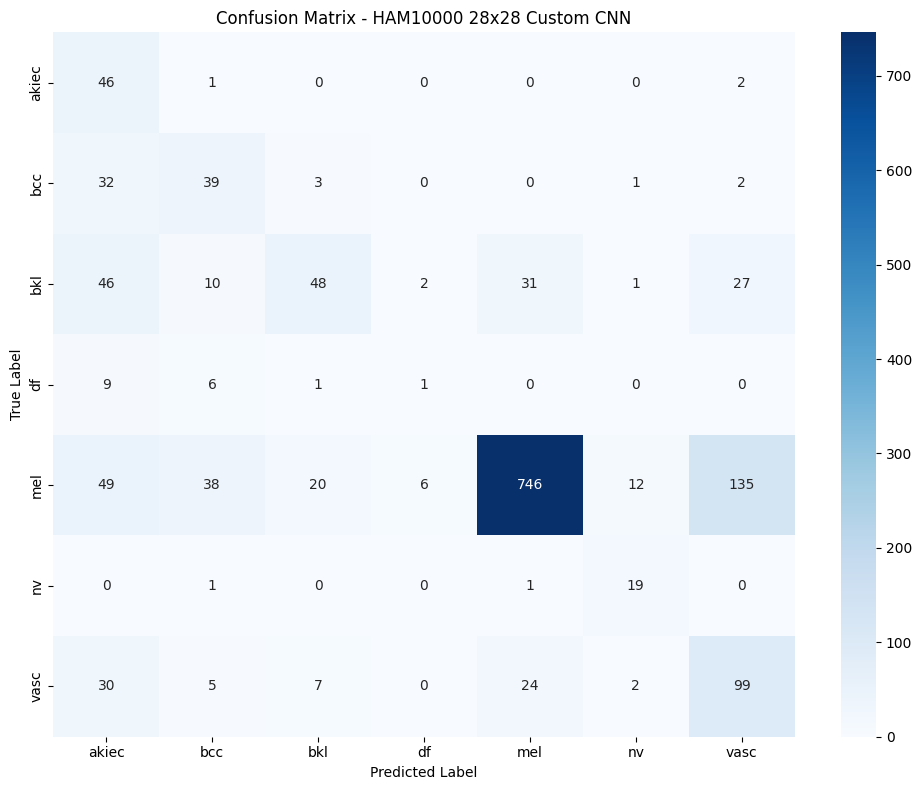

In [80]:
# 9. PREDICTIONS AND ANALYSIS

from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
y_pred_proba = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - HAM10000 28x28 Custom CNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_28x28.png', dpi=300, bbox_inches='tight')
plt.show()

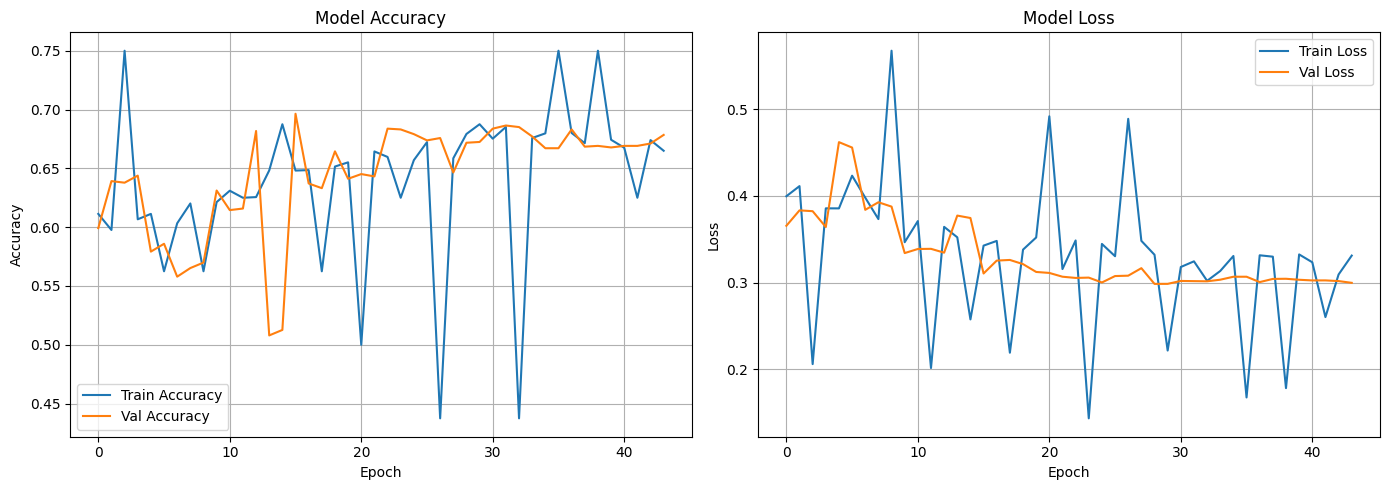

In [81]:
 #10. PLOT TRAINING HISTORY

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Changed to 2 subplots for Accuracy and Loss

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# AUC plotting code removed as 'auc' metric is no longer tracked.

plt.tight_layout()
plt.savefig('training_history_28x28.png', dpi=300, bbox_inches='tight')
plt.show()


In [82]:
# 11. SAVE MODEL

model.save('skin_cancer_classifier.keras')
print("\nModel saved as 'skin_cancer_classifier.keras'")



Model saved as 'skin_cancer_classifier.keras'


In [83]:
# 12. INFERENCE FUNCTION

def predict_lesion(image_array, model, threshold=0.5):
    """
    Predict skin lesion type from 28x28x3 image array

    Args:
        image_array: numpy array of shape (28, 28, 3) with values in [0, 255]
        model: trained Keras model
        threshold: confidence threshold for prediction
    """
    # Normalize
    img = image_array.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    predictions = model.predict(img, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    print(f"\nPredicted class: {classes[predicted_class]}")
    print(f"Confidence: {confidence:.2%}")

    if confidence < threshold:
        print(f"⚠️ Low confidence! Consider manual review.")

    print("\nAll class probabilities:")
    for cls, prob in zip(classes, predictions[0]):
        bar = '█' * int(prob * 50)
        print(f"  {cls:5s}: {prob:.2%} {bar}")

    return classes[predicted_class], confidence

# Example usage:
# test_image = X_test[0]  # Get a test image
# predict_lesion(test_image * 255, model)  # Denormalize before passing

print("TRAINING COMPLETE!")


TRAINING COMPLETE!
